In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import csv

Pobierz bazę danych dotyczącą śmiertelnych interwencji policji w USA, a następnie wczytaj ją do obiektu DataFrame.

In [2]:
df = pd.read_csv('fatal-police-shootings-data.csv')
df.head(5)

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


Przekształć tabelę w taki sposób, aby wskazywała zestawienie jednocześnie liczby ofiar interwencji według rasy (‘race’) oraz tego, czy wykazywały one oznaki choroby psychicznej (‘signs_of_mental_illness’).

In [10]:
df['race'].fillna('unknown', inplace=True)
mental_illness = df.pivot_table(values='name', index='race', columns='signs_of_mental_illness', aggfunc='count',fill_value=0, margins=True)
mental_illness

signs_of_mental_illness,False,True,All
race,,,
A,69,24,93
B,1114,184,1298
H,745,157,902
N,64,14,78
O,37,11,48
W,1763,713,2476
unknown,408,113,521
All,4200,1216,5416


In [11]:
def mental_illness_percent(row):
    percent = (row[True]/row['All'])*100
    return percent

mental_illness['Mental_illness_percent'] = mental_illness.apply(lambda row: mental_illness_percent(row), axis = 1)
mental_illness

signs_of_mental_illness,False,True,All,Mental_illness_percent
race,,,,
A,69,24,93,25.806452
B,1114,184,1298,14.175655
H,745,157,902,17.405765
N,64,14,78,17.948718
O,37,11,48,22.916667
W,1763,713,2476,28.796446
unknown,408,113,521,21.689060
All,4200,1216,5416,22.451994


In [12]:
mental_illness.loc[mental_illness['Mental_illness_percent'] == mental_illness['Mental_illness_percent'].max()]

signs_of_mental_illness,False,True,All,Mental_illness_percent
race,,,,
W,1763,713,2476,28.796446


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['week_day'] = df['date'].dt.day_name()
df['week_day']

0         Friday
1         Friday
2       Saturday
3         Sunday
4         Sunday
          ...   
5411    Saturday
5412    Saturday
5413      Monday
5414     Tuesday
5415     Tuesday
Name: week_day, Length: 5416, dtype: object

In [104]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
intervention_day = df.groupby('week_day')['date'].count().reindex(days)
intervention_day

week_day
Monday       726
Tuesday      816
Wednesday    829
Thursday     810
Friday       761
Saturday     721
Sunday       753
Name: date, dtype: int64

<AxesSubplot:xlabel='week_day'>

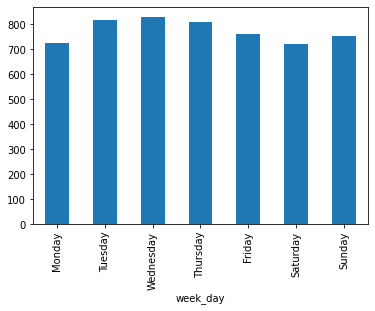

In [105]:
intervention_day.plot.bar(x='week_day', y=None)

In [106]:
data = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population', header=0)
states_by_population = data[0]

states_by_population.columns = range(states_by_population.columns.size)
population_of_state = states_by_population[[2, 3]]
population_of_state_cleaned = population_of_state.dropna().drop_duplicates()
population_of_state_cleaned.rename(columns={2:'State', 3:'Population'}, inplace=True)

population_of_state_cleaned.head(5)

,State,Population
0,California,39512223
1,Texas,28995881
2,New York,21477737
3,Florida,19453561
4,Illinois,12801989


In [108]:
data2 = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._state_and_territory_abbreviations', header=0)
abbreviations = data2[0]

abbreviations.columns = range(abbreviations.columns.size)

shortcuts = abbreviations[[0, 5]]
shortcuts_cleaned = shortcuts.dropna().drop_duplicates()
shortcuts_cleaned.rename(columns={0:'State', 5:'Codes'}, inplace=True)

shortcuts_cleaned.head(5)

,State,Codes
8,Name and status of region,USPS
11,Alabama,AL
12,Alaska,AK
13,Arizona,AZ
14,Arkansas,AR


In [110]:
add_population_shortcuts = pd.merge(population_of_state_cleaned, shortcuts_cleaned, how='inner', on='State')
add_population_shortcuts.head(5)

,State,Population,Codes
0,California,39512223,CA
1,Texas,28995881,TX
2,New York,21477737,NY
3,Florida,19453561,FL
4,Illinois,12801989,IL


In [111]:
incident_state = df.groupby('state')['id'].count() # obliczam ile było interwencji w poszczególnych stanach

interventions = incident_state.to_frame(name='Incicents') # konwertuję na DataFrame

interventions.reset_index(inplace=True) # restartuję indeks

interventions.rename(columns={'state':'Codes'}, inplace=True) # muszę zmienić nazwę kolumny ponieważ w poprzednich tabelach 'state' jest nazwą stanu a nie kodem

interventions.head(5)

,Codes,Incicents
0,AK,39
1,AL,104
2,AR,83
3,AZ,254
4,CA,799


In [112]:
full_table = pd.merge(interventions, add_population_shortcuts, how='inner', on='Codes')
full_table.head(5)

,Codes,Incicents,State,Population
0,AK,39,Alaska,731545
1,AL,104,Alabama,4903185
2,AR,83,Arkansas,3017825
3,AZ,254,Arizona,7278717
4,CA,799,California,39512223


In [113]:
def per_1000(row):
    ip_1000 = row['Incicents']/(row['Population']/1000)
    return ip_1000

full_table['Per_1000'] = full_table['Incicents']/(full_table['Population']/1000) #dzielenia kolumn przez siebie - bardziej optymalnie

full_table.head(5)

,Codes,Incicents,State,Population,Per_1000
0,AK,39,Alaska,731545,0.053312
1,AL,104,Alabama,4903185,0.021211
2,AR,83,Arkansas,3017825,0.027503
3,AZ,254,Arizona,7278717,0.034896
4,CA,799,California,39512223,0.020222
